Bibliotheken

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.stats.stattools import durbin_watson
from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import chi2
from scipy.stats import ttest_1samp
from scipy.stats import wilcoxon
from scipy.stats import binomtest
from scipy.stats import kstest

warnings.filterwarnings("ignore")

Zeitreihe einlesen und anpassen 

In [3]:
# CSV-Datei einlesen
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)

# Filtern nach Store 1
store1 = df[df['Store'] == 1].copy()

# Datensatz nach Datum sortieren und als Index setzen
store1.sort_values('Date', inplace=True)
store1.set_index('Date', inplace=True)

# Nur die Spalte Weekly_Sales extrahieren
sales = store1['Weekly_Sales']

Zeitreihe plotten

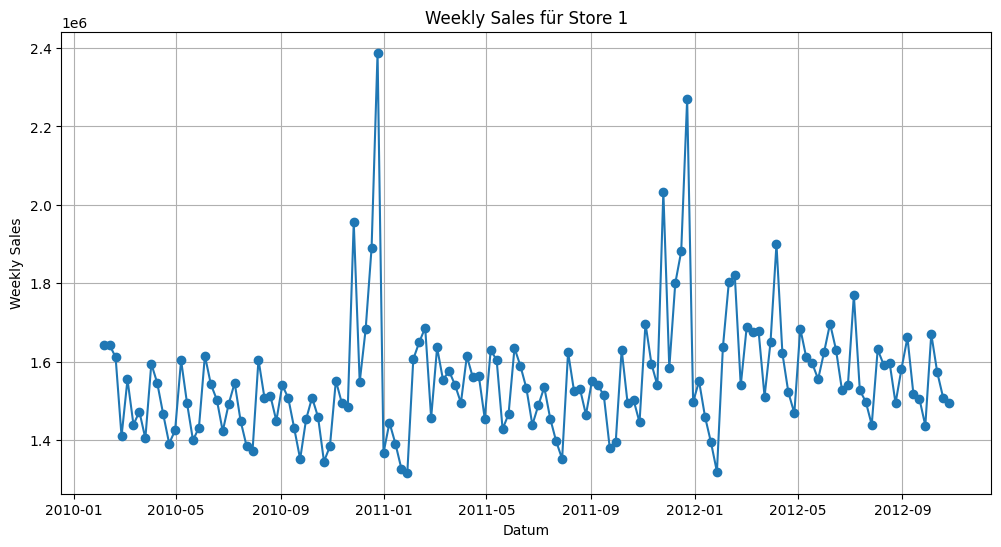

In [4]:
# Zeitreihe plotten (gesamte Daten)
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Weekly Sales für Store 1')
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

In-Sample (Residuen)

In [5]:
fitted_values = sales.shift(1)

residuals = sales - fitted_values

mean_resid = residuals.mean()
print(f"Mittelwert der Residuen: {mean_resid:.4f}")

Mittelwert der Residuen: -1056.5575


Beobachtete Werte vs. fitted Values (in-sample)

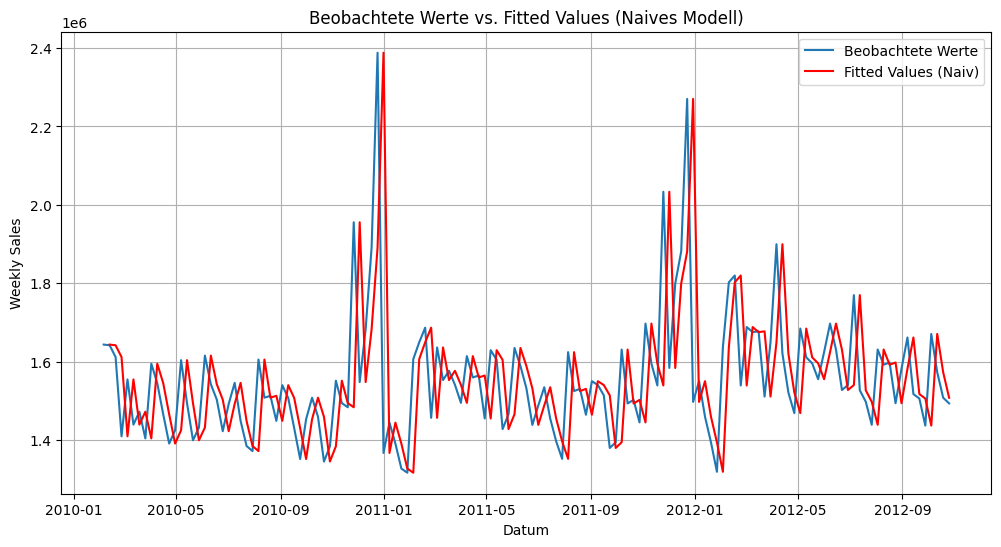

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachtete Werte')
plt.plot(fitted_values, label='Fitted Values (Naiv)', color='red')
plt.title('Beobachtete Werte vs. Fitted Values (Naives Modell)')
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

Residuen als Zeitreihe

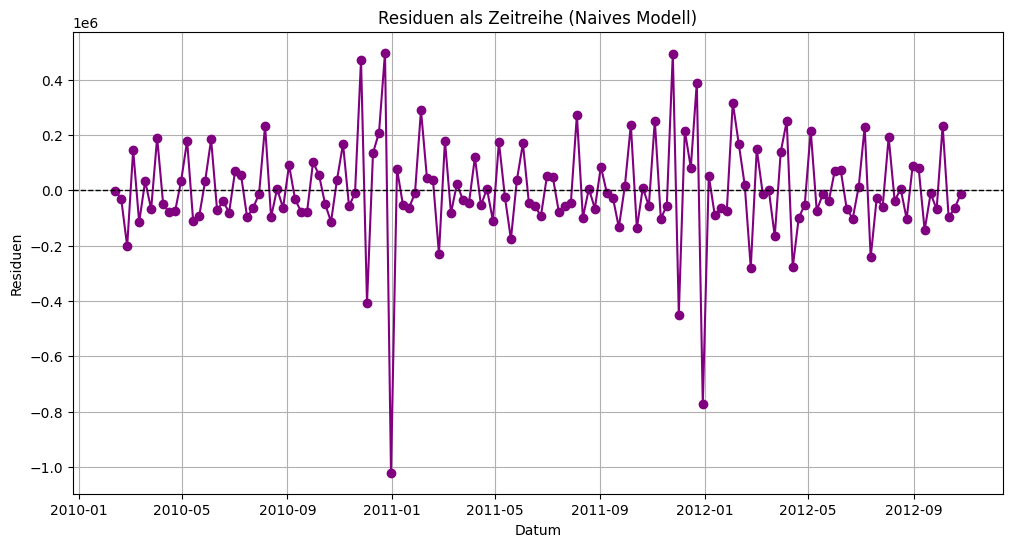

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(residuals, marker='o', linestyle='-', color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Residuen als Zeitreihe (Naives Modell)')
plt.xlabel('Datum')
plt.ylabel('Residuen')
plt.grid(True)
plt.show()

Histogramm der Residuen

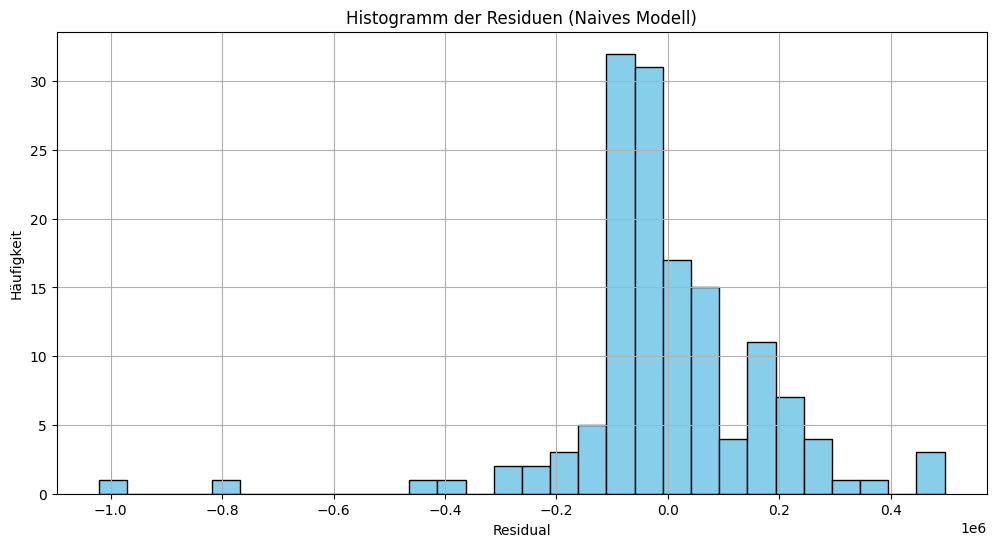

In [8]:
plt.figure(figsize=(12, 6))
plt.hist(residuals.dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Histogramm der Residuen (Naives Modell)')
plt.xlabel('Residual')
plt.ylabel('Häufigkeit')
plt.grid(True)
plt.show()

ACF

<Figure size 1200x600 with 0 Axes>

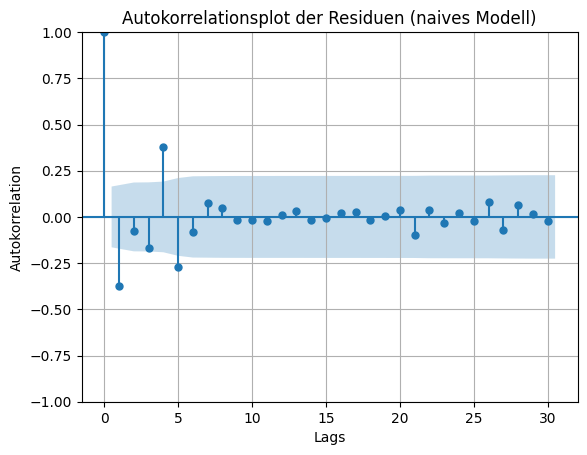

In [9]:
plt.figure(figsize=(12, 6))
plot_acf(residuals.dropna(), lags=30)
plt.title('Autokorrelationsplot der Residuen (naives Modell)')
plt.xlabel('Lags')
plt.ylabel('Autokorrelation')
plt.grid(True)
plt.show()

Box Pierce

In [10]:
resid_clean = residuals.dropna()

bp_results = acorr_ljungbox(resid_clean, lags=[10], boxpierce=True, return_df=True)

# Zugriff auf die Ergebnisse für Lag 10
bp_stat = bp_results.loc[10, 'bp_stat']
bp_pvalue = bp_results.loc[10, 'bp_pvalue']

print("Box-Pierce Test (Lag 10):")
print("Teststatistik:", bp_stat)
print("p-Wert:", bp_pvalue)

Box-Pierce Test (Lag 10):
Teststatistik: 57.988013346275004
p-Wert: 8.689786487014075e-09


Ljung-Box

In [11]:
resid_clean = residuals.dropna()

lb_results = acorr_ljungbox(resid_clean, lags=[10], boxpierce=False, return_df=True)

lb_stat = lb_results.loc[10, 'lb_stat']
lb_pvalue = lb_results.loc[10, 'lb_pvalue']

print("Ljung-Box Test (Lag 10):")
print("Teststatistik:", lb_stat)
print("p-Wert:", lb_pvalue)

Ljung-Box Test (Lag 10):
Teststatistik: 60.149000642202736
p-Wert: 3.3964501235646123e-09


Breusch-Godfrey

In [12]:
resid = residuals.dropna()

nlags = 10 #Anzahl lags die berücksichtigt werden sollen

# Erstelle ein DataFrame mit den lagged residuals
lagged_data = pd.concat([resid.shift(i) for i in range(1, nlags+1)], axis=1)
lagged_data.columns = [f'lag_{i}' for i in range(1, nlags+1)]

# Entferne Zeilen mit NaN (durch die Verschiebung)
lagged_data = lagged_data.dropna()

# Passe die Residuen so an, dass sie zu den lagged Daten passen
resid_aligned = resid.loc[lagged_data.index]

# Füge eine Konstante hinzu
X = add_constant(lagged_data)

# Schätze das OLS-Modell: Residuen ~ lagged Residuen
ols_model = OLS(resid_aligned, X).fit()

# Berechne die Breusch-Godfrey Teststatistik: n * R²
bg_stat = ols_model.nobs * ols_model.rsquared

# Berechne den p-Wert aus der Chi-Quadrat-Verteilung mit nlags Freiheitsgraden
bg_pvalue = 1 - chi2.cdf(bg_stat, nlags)

print("Breusch-Godfrey Test:")
print("Teststatistik:", bg_stat)
print("p-Wert:", bg_pvalue)

Breusch-Godfrey Test:
Teststatistik: 55.76068678772583
p-Wert: 2.2760436979574195e-08


Durbin-Watson

In [13]:
# Entferne NaN-Werte aus den Residuen, falls vorhanden
resid_clean = residuals.dropna()

# Berechne den Durbin-Watson-Wert
dw_stat = durbin_watson(resid_clean)

print("Durbin-Watson-Statistik:", dw_stat)


Durbin-Watson-Statistik: 2.751232724925425


Run Test

In [14]:
resid_clean = residuals.dropna()

z_stat, p_value = runstest_1samp(resid_clean, correction=True)

print("Wald-Wolfowitz-Runs-Test:")
print("Teststatistik (z):", z_stat)
print("p-Wert:", p_value)

Wald-Wolfowitz-Runs-Test:
Teststatistik (z): 2.42098674829579
p-Wert: 0.015478441524654144


T-Test

In [15]:
resid_clean = residuals.dropna()

t_stat, p_value = ttest_1samp(resid_clean, popmean=0)

print("One-Sample t-Test für den Mittelwert der Residuen:")
print("t-Statistik:", t_stat)
print("p-Wert:", p_value)


One-Sample t-Test für den Mittelwert der Residuen:
t-Statistik: -0.06814061133152935
p-Wert: 0.9457702364033456


Wilcoxon-Vorzeichen-Rang-Test

In [16]:
resid_clean = residuals.dropna()

stat, p_value = wilcoxon(resid_clean)

print("Wilcoxon-Vorzeichen-Rang-Test für die Residuen:")
print("Teststatistik:", stat)
print("p-Wert:", p_value)

Wilcoxon-Vorzeichen-Rang-Test für die Residuen:
Teststatistik: 4856.0
p-Wert: 0.6534068558503132


Binomial-Vorzeichen-Test

In [17]:
resid_clean = residuals.dropna()

# Zähle, wie viele Residuen positiv sind
n_total = len(resid_clean)
n_positive = (resid_clean > 0).sum()

# Führe den Binomial-Vorzeichen-Test durch
# Nullhypothese: p = 0.5, alternative: two-sided
p_value = binomtest(n_positive, n_total, p=0.5, alternative='two-sided')

print("Binomial-Vorzeichen-Test:")
print("Anzahl positiver Residuen:", n_positive)
print("Gesamtanzahl der Residuen:", n_total)
print("p-Wert:", p_value)

Binomial-Vorzeichen-Test:
Anzahl positiver Residuen: 62
Gesamtanzahl der Residuen: 142
p-Wert: BinomTestResult(k=62, n=142, alternative='two-sided', statistic=0.43661971830985913, pvalue=0.15344375016434322)


Kolmogorov-Mirnov-Test

In [18]:
resid_clean = residuals.dropna()

# Schätze Mittelwert und Standardabweichung der Residuen
mean_resid = resid_clean.mean()
std_resid = resid_clean.std()

# Führe den One-Sample KS-Test durch:
# Vergleiche die Verteilung der Residuen mit der Normalverteilung (N(mean_resid, std_resid))
d_stat, p_value = kstest(resid_clean, 'norm', args=(mean_resid, std_resid))

print("Kolmogorov-Smirnov-Test:")
print("D-Statistik:", d_stat)
print("p-Wert:", p_value)

Kolmogorov-Smirnov-Test:
D-Statistik: 0.16965915686618643
p-Wert: 0.0004828913711769518


Goldfeld-Quand Test

In [19]:
# Sicherstellen, dass Residuen und fitted values denselben Index haben:
resid_aligned = residuals.dropna()
fitted_aligned = fitted_values.dropna()

# Gemeinsamen Index berechnen, um nur die übereinstimmenden Beobachtungen zu verwenden:
common_index = resid_aligned.index.intersection(fitted_aligned.index)
resid_aligned = resid_aligned.loc[common_index]
fitted_aligned = fitted_aligned.loc[common_index]

# Verwende die fitted values als exogene Variable.
# Da exog als 2D-Array erwartet wird, formen wir sie entsprechend um.
exog = fitted_aligned.values.reshape(-1, 1)

# Führe den Goldfeld-Quandt-Test durch.
# Unter der Nullhypothese wird Homoskedastizität (konstante Varianz) angenommen.
gq_stat, gq_pvalue, ratio = het_goldfeldquandt(resid_aligned, exog)

print("Goldfeld-Quandt Test für Heteroskedastizität:")
print("Teststatistik:", gq_stat)
print("p-Wert:", gq_pvalue)


Goldfeld-Quandt Test für Heteroskedastizität:
Teststatistik: 0.9507632639119946
p-Wert: 0.5833423399162905


Breusch-Pagan Test

In [20]:
# Sicherstellen, dass Residuen und fitted values denselben Index haben:
resid_aligned = residuals.dropna()
fitted_aligned = fitted_values.dropna()

# Gemeinsamen Index berechnen:
common_index = resid_aligned.index.intersection(fitted_aligned.index)
resid_aligned = resid_aligned.loc[common_index]
fitted_aligned = fitted_aligned.loc[common_index]

# Bereite die exogene Variable vor: Wir verwenden die fitted values.
# Füge eine Konstante hinzu, da der Test einen konstanten Term erwartet.
exog = fitted_aligned.values.reshape(-1, 1)
exog = np.hstack([np.ones((exog.shape[0], 1)), exog])

# Führe den Breusch-Pagan-Test durch.
# Die Funktion gibt ein Tuple zurück: (LM-Statistik, LM p-Wert, F-Statistik, F p-Wert)
bp_test = het_breuschpagan(resid_aligned, exog, False)

print("Breusch-Pagan Test Ergebnisse:")
print("LM-Statistik:", bp_test[0])
print("LM p-Wert:", bp_test[1])
print("F-Statistik:", bp_test[2])
print("F p-Wert:", bp_test[3])

Breusch-Pagan Test Ergebnisse:
LM-Statistik: 292.0465888002892
LM p-Wert: 1.7808545590730184e-65
F-Statistik: 98.51691881007217
F p-Wert: 6.583847617079196e-18


Koenker-Basset Test

In [21]:
# Sicherstellen, dass Residuen und fitted values denselben Index haben:
resid_aligned = residuals.dropna()
fitted_aligned = fitted_values.dropna()

# Gemeinsamen Index berechnen:
common_index = resid_aligned.index.intersection(fitted_aligned.index)
resid_aligned = resid_aligned.loc[common_index]
fitted_aligned = fitted_aligned.loc[common_index]

# Bereite die exogene Variable vor: Wir verwenden die fitted values.
# Füge eine Konstante hinzu, da der Test einen konstanten Term erwartet.
exog = fitted_aligned.values.reshape(-1, 1)
exog = np.hstack([np.ones((exog.shape[0], 1)), exog])


bp_test = het_breuschpagan(resid_aligned, exog, True)

print("Koenker-Basset Test Ergebnisse:")
print("LM-Statistik:", bp_test[0])
print("LM p-Wert:", bp_test[1])
print("F-Statistik:", bp_test[2])
print("F p-Wert:", bp_test[3])

Koenker-Basset Test Ergebnisse:
LM-Statistik: 58.65161490774506
LM p-Wert: 1.8821357931439102e-14
F-Statistik: 98.51691881007218
F p-Wert: 6.583847617079196e-18


Residuen Box Plot

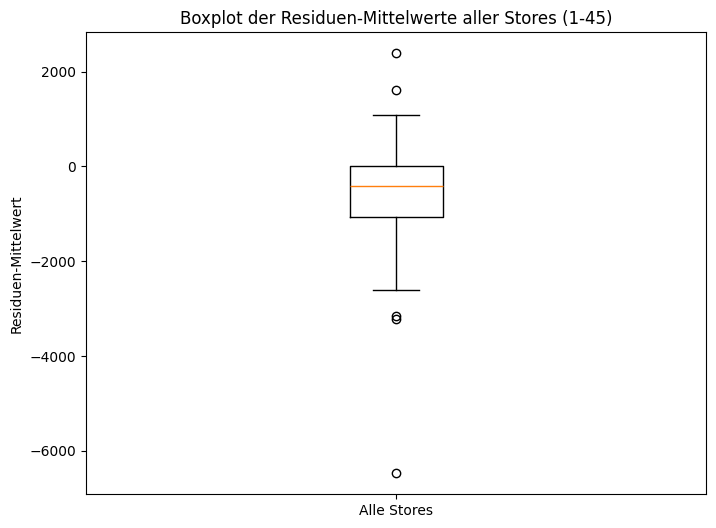

In [22]:
resid_means = []

# Für jeden Store (1 bis 45)
for store in range(1, 46):
    # Filtere die Daten für den aktuellen Store
    store_data = df[df['Store'] == store].copy()
    
    # Sortiere nach Datum und setze das Datum als Index
    store_data.sort_values('Date', inplace=True)
    store_data.set_index('Date', inplace=True)
    
    # Extrahiere die Weekly_Sales
    sales = store_data['Weekly_Sales']
    
    # Naives Modell: Fitted Values = vorheriger Wert (shift)
    fitted_values = sales.shift(1)
    
    # Residuen berechnen: Beobachtete Werte minus Fitted Values
    residuals = sales - fitted_values
    
    # Berechne den Mittelwert der Residuen (ignoriere NaN)
    mean_resid = residuals.mean()
    resid_means.append(mean_resid)

# Erstelle einen Boxplot der Residuen-Mittelwerte aller Stores
plt.figure(figsize=(8,6))
plt.boxplot(resid_means)
plt.title("Boxplot der Residuen-Mittelwerte aller Stores (1-45)")
plt.ylabel("Residuen-Mittelwert")
plt.xticks([1], ["Alle Stores"])
plt.show()